In [67]:
import random
import re
import string

import numpy as np
import keras.api as keras
from tensorflow.python.data import Dataset
import tensorflow as tf

In [68]:
with open('ukr.txt') as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, ukr, _ = line.split("\t")
    ukr = "[start] " + ukr + " [end]"
    text_pairs.append((eng, ukr))

In [69]:
for _ in range(5):
    print(random.choice(text_pairs))

("I don't think Tom knows where I live.", '[start] Не думаю, що Том знає, де я живу. [end]')
('Tom is an excellent lawyer.', '[start] Том - відмінний адвокат. [end]')
('I wonder why Tom resigned.', '[start] Мені цікаво, чому Том пішов у відставку. [end]')
('I want you to let me go.', '[start] Я хочу, щоб ти мене відпустив. [end]')
('Tom loved to travel.', '[start] Том любив подорожувати. [end]')


In [70]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

159432 total pairs
111604 training pairs
23914 validation pairs
23914 test pairs


In [71]:
strip_chars = string.punctuation.replace("[", "").replace("]", "")

def ukr_standardization(input_string):
    return tf.strings.regex_replace(tf.strings.lower(input_string), '[%s]' % re.escape(strip_chars), '')

vocab_size = 30000
seq = 20
batch_size = 128

eng_vectorization = keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=seq
)
ukr_vectorization = keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=seq + 1,
    standardize=ukr_standardization
)

train_eng_texts = [pair[0] for pair in train_pairs]
train_ukr_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
ukr_vectorization.adapt(train_ukr_texts)

In [72]:
def format_dataset(eng, ukr):
    f_eng = eng_vectorization(eng)
    f_ukr = ukr_vectorization(ukr)
    return (
        {
            "encoder_inputs": f_eng,
            "decoder_inputs": f_ukr[:, :-1]
        },
        f_ukr[:, 1:]
    )

def make_dataset(pairs):
    eng_texts, ukr_texts = zip(*pairs)
    eng_texts = np.array(eng_texts)
    ukr_texts = np.array(ukr_texts)
    dataset = Dataset.from_tensor_slices((eng_texts, ukr_texts)).batch(batch_size).map(format_dataset)
    return dataset.cache().shuffle(4096).prefetch(16)

In [73]:
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

for inputs, outputs in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f'outputs.shape: {outputs.shape}')

inputs["encoder_inputs"].shape: (128, 20)
inputs["decoder_inputs"].shape: (128, 20)
outputs.shape: (128, 20)


In [74]:
import keras.api.ops as ops

class TransformerEncoder(keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_projection = keras.Sequential([
            keras.layers.Dense(dense_dim, activation="relu"),
            keras.layers.Dense(embed_dim),
        ])
        self.layer_norm_1 = keras.layers.LayerNormalization()
        self.layer_norm_2 = keras.layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_out = self.attention(query=inputs, key=inputs, value=inputs, attention_mask=padding_mask)
        proj_input = self.layer_norm_1(inputs + attention_out)
        proj_output = self.dense_projection(proj_input)
        return self.layer_norm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

class PositionalEmbedding(keras.layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embedding = keras.layers.Embedding(vocab_size, embed_dim)
        self.position_embedding = keras.layers.Embedding(sequence_length, embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embedding(inputs)
        embedded_positions = self.position_embedding(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

class TransformerDecoder(keras.layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_projection = keras.Sequential([
            keras.layers.Dense(latent_dim, activation="relu"),
            keras.layers.Dense(embed_dim)
        ])
        self.layer_norm_1 = keras.layers.LayerNormalization()
        self.layer_norm_2 = keras.layers.LayerNormalization()
        self.layer_norm_3 = keras.layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        inputs, encoder_outputs = inputs
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            inputs_padding_mask, encoder_outputs_padding_mask = mask
        else:
            inputs_padding_mask, encoder_outputs_padding_mask = None, None

        attention_out_1 = self.attention_1(query=inputs, key=inputs, value=inputs, attention_mask=causal_mask, query_mask=inputs_padding_mask)
        out_1 = self.layer_norm_1(inputs + attention_out_1)

        attention_out_2 = self.attention_2(query=out_1, value=encoder_outputs, key=encoder_outputs, query_mask=inputs_padding_mask, key_mask=encoder_outputs_padding_mask)
        out_2 = self.layer_norm_2(out_1 + attention_out_2)

        proj_output = self.dense_projection(out_2)
        return self.layer_norm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

In [75]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(seq, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(seq, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)([x, encoder_outputs])
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

transformer = keras.Model(
    {"encoder_inputs": encoder_inputs, "decoder_inputs": decoder_inputs},
    decoder_outputs,
    name="transformer",
)

In [76]:
epochs = 30  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop",
    loss=keras.losses.SparseCategoricalCrossentropy(ignore_class=0),
    metrics=["accuracy"],
)

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  7,685,120 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, None)      │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  7,685,120 │ decoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  3,155,456 │ positional_embed… │
│ (TransformerEncode… │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, None)      │          0 │ decoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  5,259,520 │ positional_embed… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
│                     │                   │            │ not_equal_5[0][0… │
│                     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, None, 256) │          0 │ transformer_deco… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, None,      │  7,710,000 │ dropout_11[0][0]  │
│                     │ 30000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,495,216 (120.14 MB)

 Trainable params: 31,495,216 (120.14 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
hist = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=0)

W0000 00:00:1736789643.818043  138295 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-01-13 19:34:15.170371: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_2', 32 bytes spill stores, 28 bytes spill loads

W0000 00:00:1736789668.511096  138290 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-01-13 19:34:39.758974: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_2', 8 bytes spill stores, 8 bytes spill loads

W0000 00:00:1736789710.690789  138290 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseS

In [78]:
from matplotlib import pyplot as plt

i = 0
naming = []
def show_history_plot(history_dict):
    lv = history_dict["loss"]
    vlv = history_dict["val_loss"]
    epch = range(1, len(lv) + 1)
    plt.plot(epch, lv, "bo", label="Training loss")
    plt.plot(epch, vlv, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

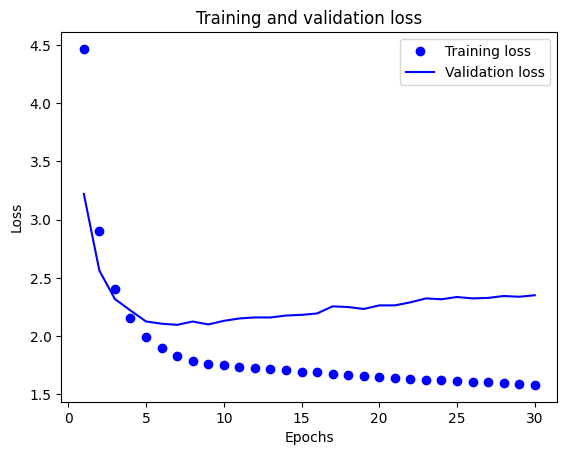

In [79]:
show_history_plot(hist.history)

In [80]:
ukr_vocab = ukr_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(ukr_vocab)), ukr_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = ukr_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer(
            {
                "encoder_inputs": tokenized_input_sentence,
                "decoder_inputs": tokenized_target_sentence,
            }
        )

        # ops.argmax(predictions[0, i, :]) is not a concrete value for jax here
        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [84]:
test_eng_texts = [pair for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence[0])
    print(f'Англійська (оригінал): {input_sentence[0]}')
    print(f'Українська (переклад): {translated}')
    print(f'Українська (оригінал): {input_sentence[1]}')

Англійська (оригінал): How long will Tom be in Boston?
Українська (переклад): [start] Скільки часу Том буде у Бостоні [end]
Українська (оригінал): [start] Скільки часу Том буде в Бостоні? [end]
Англійська (оригінал): Maybe Tom doesn't want anything.
Українська (переклад): [start] Можливо Том нічого не хоче [end]
Українська (оригінал): [start] Може, Том нічого не хоче. [end]
Англійська (оригінал): How did Tom get to work this morning?
Українська (переклад): [start] Як Том встав на цю ранок [end]
Українська (оригінал): [start] Як Том дістався на роботу сьогодні вранці? [end]
Англійська (оригінал): It looks like Tom is happy.
Українська (переклад): [start] Том здається щасливий [end]
Українська (оригінал): [start] Том, здається, щасливий. [end]
Англійська (оригінал): Do you know her father?
Українська (переклад): [start] Ви знаєте її батька [end]
Українська (оригінал): [start] Ви знаєте її батька? [end]
Англійська (оригінал): The boy remained silent.
Українська (переклад): [start] Хлопець

In [89]:
tr = decode_sequence("Yesterday I played the game and I lost")
print(tr)

[start] Я вчора грав у мою гру [end]
